# **GE - TD sur la détection de tumeurs dans des mammographies avec  Faster-RCNN**

# **1. Install les APIs pertinentes**

Exécutez la cellule suivante.

In [1]:
%%bash

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install
cd ..
cd ..

# Install torchvision useful functions
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0


cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

cd ..

pip install pycocotools

running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I../common -I/usr/include/python3.10 -c ../common/maskApi.c -o build/temp.linux-x86_64-cpython-310/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I../common -I/usr/include/python3.10 -c pycocotools/_mask.c -o build/temp.linux-x86_64-cpython-310/pycocotools/_mas

Cloning into 'cocoapi'...
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
   46 |       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
      |       ^~~
../common/maskApi.c:46:49: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
   46 |       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
      |                                                 ^
../common/maskApi.c: In function ‘rleFrPoly’:
../common/maskApi.c:166:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
  166 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5

# **2. Import des packages Python pertinent pour le TD**

Exécutez la cellule suivante.

In [14]:
!pip install torch==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.

In [1]:
import os
import numpy as np
import torch
import time
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from engine import train_one_epoch, evaluate
import utils
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# **3. La base de données MIAS**


Les exercices de ce TP utiliseront tous la base données publique appelée
 **Mammographic Image Analysis Society (MIAS) dataset**.

- Le dataset MIAS réunit **322** mammographies gauche et droite.
- La taille d'une mammographie est de 1024x1024 pixels.
- Chaque mammographie comporte plusieurs annotations (cf. le fichier Info.txt), par exemple:
`mdb010 F CIRC B 525 425 33`
                1st column: MIAS database reference number.

                2nd column: Character of background tissue:
                                F - Fatty
                                G - Fatty-glandular
                                D - Dense-glandular

                3rd column: Class of abnormality present:
                                CALC - Calcification
                                CIRC - Well-defined/circumscribed masses
                                SPIC - Spiculated masses
                                MISC - Other, ill-defined masses
                                ARCH - Architectural distortion
                                ASYM - Asymmetry
                                NORM - Normal

                4th column: Severity of abnormality:
                                B - Benign
                                M - Malignant

                5th,6th columns: x,y image-coordinates of centre of abnormality.

                7th column: Approximate radius (in pixels) of a circle enclosing the abnormality.

## 3.a. Télécharger le dataset MIAS

Exécutez la cellule suivante pour télécharger le dataset MIAS.

In [2]:
%%bash

# Download the ddataset
mkdir mias-db && cd mias-db
wget http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
tar -zxvf all-mias.tar.gz
rm all-mias.tar.gz && cd ..

Info.txt
Licence.txt
README
mdb001.pgm
mdb002.pgm
mdb003.pgm
mdb004.pgm
mdb005.pgm
mdb006.pgm
mdb007.pgm
mdb008.pgm
mdb009.pgm
mdb010.pgm
mdb011.pgm
mdb012.pgm
mdb013.pgm
mdb014.pgm
mdb015.pgm
mdb016.pgm
mdb017.pgm
mdb018.pgm
mdb019.pgm
mdb020.pgm
mdb021.pgm
mdb022.pgm
mdb023.pgm
mdb024.pgm
mdb025.pgm
mdb026.pgm
mdb027.pgm
mdb028.pgm
mdb029.pgm
mdb030.pgm
mdb031.pgm
mdb032.pgm
mdb033.pgm
mdb034.pgm
mdb035.pgm
mdb036.pgm
mdb037.pgm
mdb038.pgm
mdb039.pgm
mdb040.pgm
mdb041.pgm
mdb042.pgm
mdb043.pgm
mdb044.pgm
mdb045.pgm
mdb046.pgm
mdb047.pgm
mdb048.pgm
mdb049.pgm
mdb050.pgm
mdb051.pgm
mdb052.pgm
mdb053.pgm
mdb054.pgm
mdb055.pgm
mdb056.pgm
mdb057.pgm
mdb058.pgm
mdb059.pgm
mdb060.pgm
mdb061.pgm
mdb062.pgm
mdb063.pgm
mdb064.pgm
mdb065.pgm
mdb066.pgm
mdb067.pgm
mdb068.pgm
mdb069.pgm
mdb070.pgm
mdb071.pgm
mdb072.pgm
mdb073.pgm
mdb074.pgm
mdb075.pgm
mdb076.pgm
mdb077.pgm
mdb078.pgm
mdb079.pgm
mdb080.pgm
mdb081.pgm
mdb082.pgm
mdb083.pgm
mdb084.pgm
mdb085.pgm
mdb086.pgm
mdb087.pgm
mdb088.pgm
mdb0

mkdir: cannot create directory ‘mias-db’: File exists
--2023-06-25 19:42:16--  http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
Resolving peipa.essex.ac.uk (peipa.essex.ac.uk)... 155.245.93.3
Connecting to peipa.essex.ac.uk (peipa.essex.ac.uk)|155.245.93.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111154265 (106M) [application/gzip]
Saving to: ‘all-mias.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  172K 10m31s
    50K .......... .......... .......... .......... ..........  0%  450K 7m16s
   100K .......... .......... .......... .......... ..........  0%  367K 6m29s
   150K .......... .......... .......... .......... ..........  0% 2.77M 5m1s
   200K .......... .......... .......... .......... ..........  0% 1.50M 4m15s
   250K .......... .......... .......... .......... ..........  0%  530K 4m6s
   300K .......... .......... .......... .......... ..........  0% 3.23M 3m36s
   350K .......... .......... .......... ..........

## 3.b. Répartir le dataset entre train, validation et test sets.

#### **Vous devez trouver les coordonnées des bounding box carrées englobant les tumeurs**.

Dans le dataset MIAS une anormalité dans la mammographie est localisée par les coordonnées du pixel $(x, y)$ correspondant au centre de la lésion ainsi que le rayon $r$ en pixels du cercle englobant la lésion. En utilisant $(x, y)$ et $r$, vous pouvez en déduire les coordonnées de la bounding box carrée correspondante entourant la lésion.

- Complétez la fonction `get_square_bounding_box(file_info)` qui retourne les coordonnées de la bounding box.




In [3]:
# Path to database
mias_db_path = './mias-db/'
info_file = 'Info.txt'

In [4]:
def get_square_bounding_box(file_info):

    if 'NORM' in file_info:
        bbox = []
    else:
        x, y, r = int(file_info.split(' ')[4]), 1024-int(file_info.split(' ')[5]), int(file_info.split(' ')[6])
        """FILL HERE"""
        bbox = [x-r, y-r, x+r, y+r]
    return bbox


def read_dataset_info(mias_db_path, info_file, accepted_format=None, to_exclude=[]):
    with open(os.path.join(mias_db_path, info_file), 'r') as fp:
        if accepted_format is not None:
            info = [f.strip() for f in fp.readlines() if f.startswith(accepted_format) and not f.startswith(to_exclude)]
        else:
            info = [f.strip() for f in fp.readlines() if f.startswith('mdb') and not f.startswith(to_exclude)]

    dataset_info = {}
    for file_info in info:
        img_path = os.path.join(mias_db_path, file_info.split(' ')[0] + '.pgm')
        class_name = "NOTUMOUR" if 'NORM' in file_info.split(' ')[2] else "TUMOUR"
        bbox = get_square_bounding_box(file_info)

        dataset_info[img_path] = {
                                   "class_name": class_name,
                                   "bbox": bbox}
    return dataset_info

In [5]:
# Some cases contain abnormalities so we will exclude them.
to_exclude = ('mdb216', 'mdb233', 'mdb245', 'mdb059')
# Images to include in the validation set
val_set = ('mdb001', 'mdb002', 'mdb005', 'mdb010', 'mdb012', 'mdb013')
# Images to include in the test set
test_set = ('mdb090', 'mdb091', 'mdb121', 'mdb134', 'mdb145', 'mdb218')

In [6]:
train_dataset = read_dataset_info(mias_db_path, info_file, accepted_format=None, to_exclude=to_exclude + val_set + test_set)
validation_dataset = read_dataset_info(mias_db_path, info_file, accepted_format=val_set, to_exclude=to_exclude)
test_dataset = read_dataset_info(mias_db_path, info_file, accepted_format=test_set, to_exclude=to_exclude)

<ipython-input-7-83aa04abe788>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


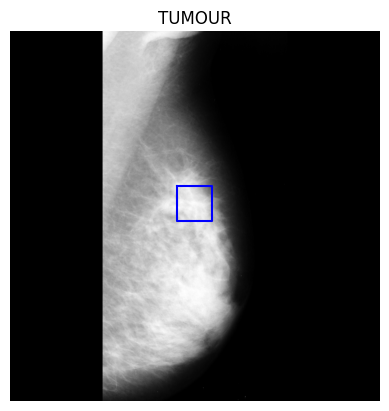

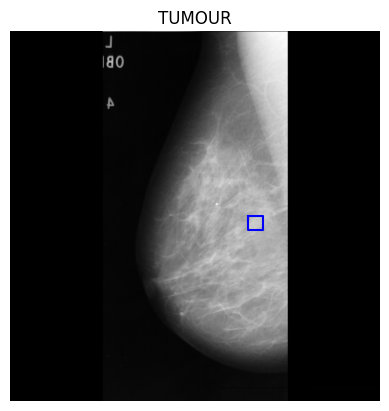

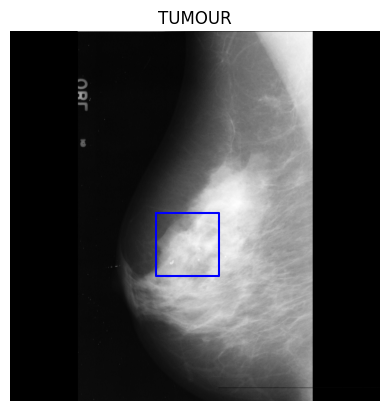

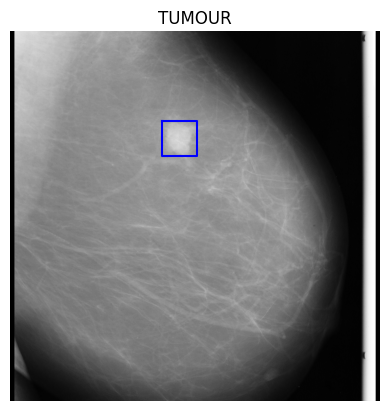

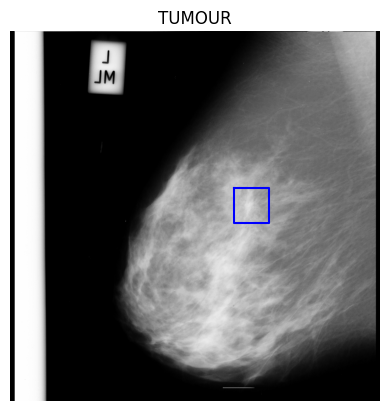

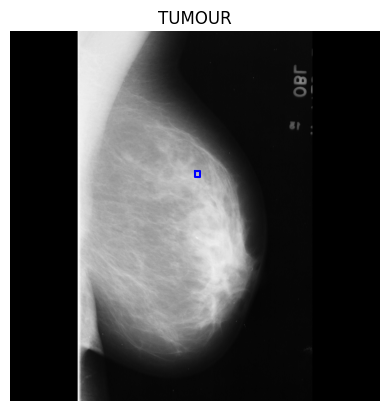

In [7]:
for img_path in test_dataset:

    image = imageio.imread(img_path)
    class_name = test_dataset[img_path]['class_name']
    x1, y1, x2, y2  = test_dataset[img_path]["bbox"]

    plt.imshow(image, cmap="gray")
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')
    plt.axis('off')
    plt.title(class_name)
    plt.show()

## 3.c. Création de la classe `Dataset`.

Pour créer un dataset vous allez devoir utiliser la classe Pytorch  `Dataset`. La structure de cette classe ressemble à ce qui suit:

        class MyDataset(torch.utils.data.Dataset):

            def __init__(self, args):
                ...

            def __getitem__(self):
                return pil_image, target

            def __len(self)__:
                return len(self.img_list)


**i. Pour créer votre propre classe `Dataset`, vous allez override plusieurs méthodes**
- le constructeur `__init__(self, args, transforms)`: Un détail important de cette méthode est qu'elle doit avoir prendre en entrée la variable `transforms`. Celle-ci sera utilisée par la méthode  `__getitem__(self, image_id)` pour faire de l'augmentation de données.
- la méthode `__getitem__(self, image_id)`. Cette fonction doit retourner une image de type PIL, et un dictionnaire `target` qui contient les informations "vérité terrain" de l'image. Par exemple, le label de classification, les coordonnées de la bounding box... Les transformations liées à l'augmentation de données ont lieu dans cette fonction grâce à la varibale `transforms`.
- la méthode `__len__(self)` qui retourne la taille du dataset.


Dans votre classe, vous devez aussi coder:

**ii. Dans le constructeur:**
- `self.img_dict`: un dictionnaire qui associe l'indice `idx` d'une image aux informations la concernant (chemin vers l'image, coordonnées de la bounding box, label de classification). __Attention__: que se passe-t-il quand il n'y a pas de lésion dans la mammographie ? Il est nécessaire de créer de fausses bounding boxes.

        self.img_dict[idx] = {'path': ...,
                              'bbox': [...],
                              'class': ...}
                             
- `self.class_names`: un dictionnaire qui associe le nom `string`des classes aux labels lus par le modèle.

        self.class_names = {"TUMOUR": 1,
                            "NOTUMOUR": 2}
                            
- `self.idx2class`: un dictionnaire qui fait l'inverse de `self.class_names`.

**iii. Nouvelles méthodes:**
- `add_random_bbox(self)`: cette fonction parcourt le dataset et créer des bounding box de façon aléatoire pour les mammographies ne présentant pas de lésion. Cela permerttra de donner des exemples de tissus sains au modèle pendant l'entraînement.
- `load_image(self, img_idx)`: cette fonction retourne une image RGB de type PIL dont l'indice sera `img_idx`.



In [8]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, split_dataset, transforms=None, name="train"):
        self.split_dataset = split_dataset
        self.name = name
        self.transforms = transforms

        self.class_names = {
            "TUMOUR": 1,
            "NOTUMOUR": 2,
        }

        self.add_random_bbox()
        self.idx2class = {self.class_names[name]: name for name in self.class_names}
        self.img_dict = {img_idx:{"path":  img_path,
                                  "class": self.class_names[self.split_dataset[img_path]['class_name']],
                                  "bbox":  self.split_dataset[img_path]['bbox']}
                          for img_idx, img_path in enumerate(self.split_dataset)}

    def __getitem__(self, img_idx):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        """FILL HERE
        Create the image, label and bbox variables using the implemented img_dict dictionary.
        """
        image = self.load_image(img_idx)
        class_name = self.img_dict[img_idx]["class"]
        bbox = self.img_dict[img_idx]["bbox"]

        # Compute the area of the bounding box
        x1, y1, x2, y2 = bbox
        area = (x2 - x1) * (y2 - y1)

        # Convert everything to tensor
        img_idx = torch.tensor([img_idx])
        bbox = torch.as_tensor([bbox], dtype=torch.float32)
        class_name = torch.as_tensor([class_name], dtype=torch.int64)
        area = torch.as_tensor([area], dtype=torch.float32)

        # Compute the area of the bounding box
#         area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
#         area = torch.as_tensor(area)

        # Use the COCO template for targets to be able to evaluate the model with COCO API
        target = {"boxes": bbox,
                  "labels": class_name,
                  "image_id": img_idx,
                  "area": area,
                  "iscrowd": torch.as_tensor([0], dtype=torch.int64)}

        # Important line! don't forget to add this
        if self.transforms:
            image, target = self.transforms(image, target)
        # return the image, the boxlist and the idx in your dataset
        return image, target

    def __len__(self):
        return len(self.split_dataset)



    def add_random_bbox(self):
        # Add a random bounding box for all images that are NORMAL.
        for img_path in self.split_dataset:
            if self.split_dataset[img_path]['class_name'] == "NOTUMOUR":

                # where is there something in the mammogram ?
                img = imageio.imread(img_path)

                # Define random radius that should not be bigger than image
                radius = np.random.randint(10, 70)

                # Set borders at zero to avoid having a bounding box that is outside the mammogram
                new_img = np.zeros(img.shape)
                new_img[radius:-radius, radius:-radius] = img[radius:-radius, radius:-radius]
                mask = new_img > 50
                mask_id_x, mask_id_y = np.where(mask)

                random_id_x, random_id_y = np.random.randint(len(mask_id_x)), np.random.randint(len(mask_id_y))
                center_x, center_y = mask_id_x[random_id_x], mask_id_y[random_id_y]
                bbox = [center_x-radius, center_y-radius, center_x+radius, center_y+radius]
                self.split_dataset[img_path]['bbox'] = bbox



    def load_image(self, img_idx):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        img_path = self.img_dict[img_idx]['path']
        image = imageio.imread(img_path)[..., np.newaxis]
        image = np.concatenate((image, image, image), axis=2)
        image = Image.fromarray(image).convert("RGB")
        return image


## 3.d. Data augmentation

La fonction `get_transform(train)` retourne les images aléatoirement pendant l'entraînement du modèle.

Afin de renverser une image et d'appliquer la même transformation aux coordonnées de la bounding box, il faut coder une classe `RandomHorizontalFlip(object)`, dont la structure est montrée ci-dessous.

class RandomHorizontalFlip(object):

        def __init__(self, prob):
            self.prob = prob

        def __call__(self, image, target):
            if random.random() < self.prob:
                height, width = image.shape[-2:]
                # Flip image
                image = image.flip(-1)
                # Flip bounding box coordinates
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
            return image, target

Vous pouvez coder vos propre fonction d'augmentaiton de données si vous le souhaitez.

    

In [9]:
import transforms as T
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## 3.e. Création des train, validation et test sets

- Créez les train, validation and test sets en utilisant la classe `CancerDataset`.
- A quel point le training set est-il déséquilibré ?

In [10]:
""" FILL HERE
create your train val and test datasets
"""
train = CancerDataset(train_dataset, get_transform(train=True), name="train")
val = CancerDataset(validation_dataset, get_transform(train=False), name="validation")
test = CancerDataset(test_dataset, get_transform(train=False), name="test")

print("Number of images in training set: {}".format(len(train)))
print("Number of images in validation set: {}".format(len(val)))
print("Number of images in test set: {}".format(len(test)))

<ipython-input-8-831e57176960>:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


Number of images in training set: 306
Number of images in validation set: 6
Number of images in test set: 6


In [11]:
# How imbalanced is the training set ?
class_counts = {"TUMOUR": 0, "NOTUMOUR": 0}
for img_idx in train.img_dict:
    class_name = train.idx2class[train.img_dict[img_idx]['class']]
    if "NO" in class_name: class_counts['NOTUMOUR'] += 1
    else: class_counts['TUMOUR'] += 1

print(class_counts)

{'TUMOUR': 99, 'NOTUMOUR': 207}


## 3.f. Visualisez quelques images et leurs bounding boxes

<ipython-input-12-f8860c912fc6>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


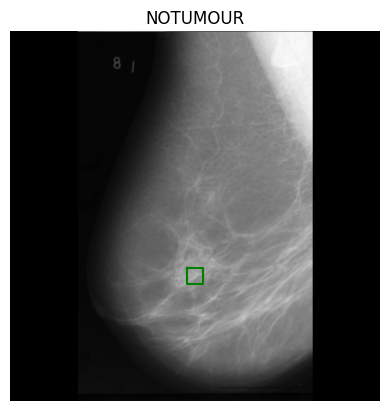

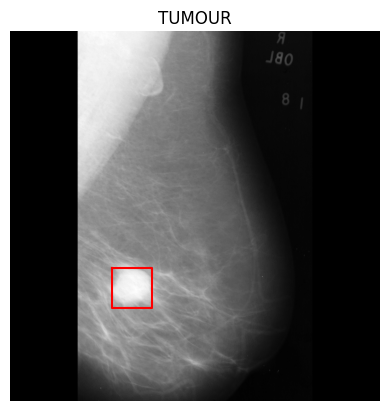

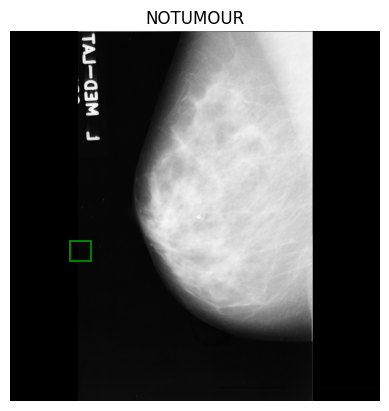

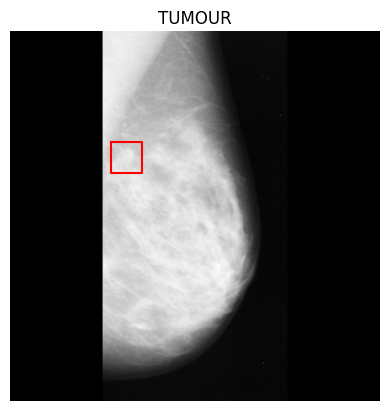

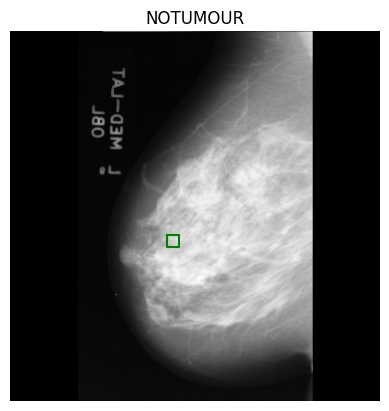

In [12]:
for img_idx in range(20, 25):

    img_path = train.img_dict[img_idx]['path']
    image = imageio.imread(img_path)
    class_name = train.idx2class[train.img_dict[img_idx]['class']]
    x1, y1, x2, y2  = train.img_dict[img_idx]["bbox"]

    plt.imshow(image, cmap="gray")
    if "NOTUMOUR" in class_name:
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'g-')
    else:
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r-')
    plt.axis('off')
    plt.title(class_name)
    plt.show()

## 3.g. Create the data loaders


In this section, we instantiate **data loaders** that will be used to generate batches of images on the fly during training.

For each of the created datasets, you need to call `torch.utils.data.DataLoader` and define :
- the `batch_size`,
- whether to randomly shuffle the dataset so the dataloaders will return random samples by setting the `shuffle` parameter to `True` or `False`. Typically, you want to shuffle your training dataset. It does not matter for the validation and test sets.
- the number of processes that should be used to load each batch using `num_workers`.

In [13]:
# Data loaders
# torch.manual_seed(1)

train_data_loader = torch.utils.data.DataLoader(
    train, batch_size=8, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    val, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

# **4. Faster Region-based Convolutional Network model - [code](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py), [article](https://arxiv.org/abs/1506.01497)**

L'architecture du modèle **FasterRCNN** comprend le RPN comme algorithme proposant des régions d'intérêt et le modèle Fast RCNN comme détecteur.

Dans cet exercice nous entraînerons un **Faster R-CNN model avec un ResNet-50-FPN backbone** à la place de VGG.

![](https://bit.ly/3BoJCjj)

>  L'entrée du modèle doit être une liste de tensors (un par image), chacun de dimensions `[C, H, W]`  (nombre de canaux de couleur d'abord) et dont les valeurs devraient être comprise environ entre à et 1.  Les images peuvent ne pas avoir les mêmes dimensions.

> Pendant l'**entraînement**, le modèle prend la liste de tensors et les dictionnaires `targets` correspondants i.e. une liste de dictionnaires. Chaque dictionnaire `target` contients:
> - `boxes` (`FloatTensor` de dimmensions `[N, 4]`): les coordonnées des bounding boxes de référents sous format [x1, y1, x2, y2], avec `0 <= x1 < x2 <= W` et `0 <= y1 < y2 <= H.`
> - `labels` (`Int64Tensor` de dimmension `[N]`): le label de classification pour chaque bounding box de référence.
>- `image_id` (`Int64Tensor` de dimmension `[1]`): l'indice identifiant l'image. Il doit être unique pour chaque image contenue dans le dataset considéré
>- `area` (`Tensor` de dimmension `[N]`): l'aire des bounding boxes. Elle est utilisée pendant l'évaluation, pour séparer les résultats des métriques en fonction de la taille des bounding boxes.

> Le modèle retourne un `Dict[Tensor]` pendant l'entraînement, qui contient le label estimé de classification et les pertes de régression pour les coordonnées des bounding boxes pour le RPN et pour le RCNN.


## Exhaustive list of Faster RCNN's input arguments

**About the architecture:**
> - `backbone (nn.Module)`: the network used to compute the features for the model.
    It should contain a out_channels attribute, which indicates the number of output
    channels that each feature map has (and it should be the same for all feature maps).
    The backbone should return a single `Tensor` or an `OrderedDict[Tensor]`.
    
**About the input data:**
> Classes:
> - `num_classes (int)`: number of output classes of the model (including the background).
    If box_predictor is specified, `num_classes` should be None.

> Image size rescaling:
> - `min_size (int)`: minimum size of the image to be rescaled before feeding it to the backbone
> - `max_size (int)`: maximum size of the image to be rescaled before feeding it to the backbone

> Image normalization:
> - `image_mean (Tuple[float, float, float])`: mean values used for input normalization.
    They are generally the mean values of the dataset on which the backbone has been trained
    on
> - `image_std (Tuple[float, float, float])`: std values used for input normalization.
    They are generally the std values of the dataset on which the backbone has been trained on
    
**About the Region Proposal Network (RPN):**

> Architecture:
>- `rpn_anchor_generator (AnchorGenerator)`: module that generates the anchors for a set of feature
    maps.
>- `rpn_head (nn.Module)`: module that computes the objectness and regression deltas from the RPN

> NMS parameters:
> - `rpn_pre_nms_top_n_train (int)`: number of proposals to keep before applying NMS during training
> - `rpn_pre_nms_top_n_test (int)`: number of proposals to keep before applying NMS during testing
> - `rpn_post_nms_top_n_train (int)`: number of proposals to keep after applying NMS during training
> - `rpn_post_nms_top_n_test (int)`: number of proposals to keep after applying NMS during testing
> - `rpn_nms_thresh (float)`: NMS threshold used for postprocessing the RPN proposals

> IoU thresholds:
>- `rpn_fg_iou_thresh (float)`: minimum IoU between the anchor and the GT box so that they can be
    considered as positive during training of the RPN.
>- `rpn_bg_iou_thresh (float)`: maximum IoU between the anchor and the GT box so that they can be
    considered as negative during training of the RPN.

> RPN parameters for training:
>- `rpn_batch_size_per_image (int)`: number of anchors that are sampled during training of the RPN
    for computing the loss
>- `rpn_positive_fraction (float)`: proportion of positive anchors in a mini-batch during training
    of the RPN

> RPN parameter for inference:
> - `rpn_score_thresh (float)`: during inference, only return proposals with a classification score
    greater than `rpn_score_thresh`
    
**About bounding box processing and proposals:**

> Architecture:
>- `box_roi_pool (MultiScaleRoIAlign)`: the module which crops and resizes the feature maps in
    the locations indicated by the bounding boxes
>- `box_head (nn.Module)`: module that takes the cropped feature maps as input
>- `box_predictor (nn.Module)`: module that takes the output of box_head and returns the
    classification logits and box regression deltas.

> Inference:
>- `box_score_thresh (float)`: during inference, only return proposals with a classification score
    greater than `box_score_thresh`
> - `box_nms_thresh (float)`: NMS threshold for the prediction head. Used during inference
> - `box_detections_per_img (int)`: maximum number of detections per image, for all classes.

> Training:
>- `box_fg_iou_thresh (float)`: minimum IoU between the proposals and the GT box so that they can be
    considered as positive during training of the classification head
>- `box_bg_iou_thresh (float)`: maximum IoU between the proposals and the GT box so that they can be
    considered as negative during training of the classification head
>- `box_batch_size_per_image (int)`: number of proposals that are sampled during training of the
    classification head
>- `box_positive_fraction (float)`: proportion of positive proposals in a mini-batch during training
    of the classification head
>- `bbox_reg_weights (Tuple[float, float, float, float])`: weights for the encoding/decoding of the
    bounding boxes



## 4.a. Normalisation des données


Calculez la valeur moyenne `image_mean` et l'écart type `image_std` du training set.

Les sorties des fonctions devra être un **tuple**, un élément (moyenne ou écart type) par canal couleur.


In [14]:
def compute_means(dataset):
    return tuple(np.mean([np.mean(dataset[idx][0].numpy(), axis=(1, 2)) for idx in tqdm(dataset.img_dict)], axis=0))

In [15]:
def compute_stds(dataset):
    return tuple(np.std([np.std(dataset[idx][0].numpy(), axis=(1, 2)) for idx in tqdm(dataset.img_dict)], axis=0))

In [16]:
image_mean = compute_means(train)
image_std = compute_stds(train)


print("Means: {}".format(image_mean))
print("Stds: {}".format(image_std))

  0%|          | 0/306 [00:00<?, ?it/s]<ipython-input-8-831e57176960>:93: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)[..., np.newaxis]
100%|██████████| 306/306 [00:10<00:00, 29.30it/s]

Means: (0.21216075, 0.21216075, 0.21216075)
Stds: (0.03238545, 0.03238545, 0.03238545)


## 4.b. Création du modèle.

Pour créer le modèle, vous devrez:
- appeler `torchvision.models.detection.fasterrcnn_resnet50_fpn` et lui donnér la moyenne et l'écart type du training set.
- indiquer le nombre de classes de notre problème:  `NOTUMOUR`, `TUMOUR` et une classe pour le fond de l'image donc 3 classes.
- remplacer la tête du prédicteur de bounding box par FastRCNN `FastRCNNPredictor`

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             image_mean=image_mean,
                                                             image_std=image_std)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 3  # intumomur + no tumour + background

# get number of input channels for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 4.c. Calculez le nombre de paramêtres du modèle

In [18]:
""" FILL HERE """
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {:.4e}".format(params))

Number of trainable parameters: 4.1082e+07


# **5. Training**



## 5.a. Optimiseur et Hyperparamètres

> Définissez l'optimiseur et les hyperparamètres associés à utiliser pendant l'entraînement:
>- learning rate initial,
>- momentum,
>- weight decay,
>- ...

> utilisez un learning rate scheduler pour réduire le learning rate progressivement pendant le training.

In [19]:
# gpu_number = 3

# torch.cuda.set_device(gpu_number)
# move model to the right device
model.cuda()
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

""" FILL HERE"""
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate
# Change the scheduler type if you wish
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.5)

## 5.b. Fonction de training et validation pour une époque.

>  Implementez votre propre fonction d'entraînement pour une seule époque. La fonction devra:
>- Parcourir le dataloader et sélectionner les batches,
>- Donner la prédiction du modèle,
>- Calculez la fonction de perte (la loss),
>- Re-initialiser l'optimiseur: pour chque mini-batch, il faut explicitement annuler tous les gradients avant de commencer la rétropropagation parce que Pytorch accumule les gradients calculés précédemment. Si on ne fait pas ça on risque une erreur `Out-Of-Memory`.
>- Faire la rétropropagation  (calcule les gradients for every pour chque paramètre dans le modèle).
>- Faire les mise-à-jour des paramètres (update les poids et biais du modèle en utilisant les gradients calculés).

> Implementez une fonction similaire mais destinées au calcul de la loss sur le validation set. Pas besoin de calculer des gradients, de rétropropager ou de faire des mises-à-jour dans cette fonction.


In [20]:
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import math
from torch.utils.tensorboard import SummaryWriter


In [ ]:
import torch.utils.tensorboard
writer = torch.utils.tensorboard.SummaryWriter()

In [ ]:
def train_one_epoch(model, optimizer, data_loader, epoch, writer):

    # Set the model in training mode: the gradients will be saved.
    model.train()

    epoch_loss = {}
    for i, values in enumerate(data_loader):
        images, targets = values

        # Create list of input images
        images = list(image.cuda() for image in images)
        # Create list of ground-truth dicionnaries
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

        # Feed the training samples to the model
        # The model returns loss_dict which contains the values of every loss functions
        loss_dict = model(images, targets)
        # Compute the global loss by summing all loss values
        global_loss = sum(loss for loss in loss_dict.values())
        loss_value = global_loss.item()

        # Increment the epoch's loss
        for k, v in loss_dict.items():
            epoch_loss[k] = epoch_loss.get(k, []) + [v.item()]
        epoch_loss['global_loss'] = epoch_loss.get('global_loss', []) + [loss_value]

        # If your loss is a Nan or infinite, you need to stop the training because it's failing.
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        # Initialize optimizer
        optimizer.zero_grad()
        # Backpropagation: compute gradients
        global_loss.backward()
        # Update the model's parameters
        optimizer.step()

    # Compute the losses over the whole epoch
    for k, v in epoch_loss.items():
        epoch_loss[k] = np.mean(v)
        writer.add_scalar('Training Loss/{}'.format(k), np.mean(v), epoch)
    writer.flush()
    return epoch_loss

In [ ]:
def validate_one_epoch(model, data_loader, epoch, writer):

    validation_loss = {}
    for i, values in enumerate(data_loader):
        images, targets = values
        images = list(image.cuda() for image in images)
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        global_loss = sum(loss for loss in loss_dict.values())
        loss_value = global_loss.item()

        # Increment the epoch's loss
        for k, v in loss_dict.items():
            validation_loss[k] = validation_loss.get(k, []) + [v.item()]
        validation_loss['global_loss'] = validation_loss.get('global_loss', []) + [loss_value]

    # Compute the losses over the whole epoch
    for k, v in validation_loss.items():
        validation_loss[k] = np.mean(v)
        writer.add_scalar('Validation Loss/{}'.format(k), np.mean(v), epoch)
    writer.flush()
    return validation_loss

## 5.c. Entraînez le modèle

Définissiez le nombre d'époques `num_epochs`pendant lesquelles on entraîne le modèle.

In [ ]:
num_epochs = 2

for epoch in range(1, num_epochs+1):

    # Train for one epoch, printing every 10 iterations
    start = time.time()
    epoch_loss = train_one_epoch(model, optimizer, train_data_loader, epoch, writer)
    result = "Epoch {} [{:.1f} s] - lr: {:.3e}:".format(epoch, time.time()-start, lr_scheduler.get_last_lr()[0])
    for k, v in epoch_loss.items(): result += "\t{}: {:.6f}".format(k, v)
    print(result)

    # Compute losses over the validation set
    validation_loss = validate_one_epoch(model, val_data_loader, epoch, writer)
    result = "Validation:"
    for k, v in validation_loss.items(): result += "\t{}: {:.6f}".format(k, v)
    print(result)


    # Update the learning rate
    lr_scheduler.step()

    # Save the model if you wish. You can add a criteria before saving, for example
    # if the validation decreases.
    # save_path = "/content/drive/My Drive/mva_td/saved_models/my_model"
    # torch.save(model, save_path)

#     torch.cuda.empty_cache()

## 5.d. Visualiser les courbes d'apprentissage avec Tensorboard

Est-ce que le modèle overfit ?


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir './runs/'

from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000)

In [ ]:
!tensorboard --logdir=runs!


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6007/ (Press CTRL+C to quit)


# **6. Evaluation over the test set**

> Pendant la phase d'**inference**, la modèle ne prend en entrée que la liste de tensors et retourne les prédictions sour la forme d'une liste de dictionnaires `List[Dict[Tensor]]`, un dictionnaire par iamge d'entrée. Les champs d'un dictionnaire sont les suivants, N étant e nombre de détections effectuées:
> - `boxes` (`FloatTensor` de dimensions `[N, 4]`): les boxes estimées par le modèle sous format `[x1, y1, x2, y2]`, avec `0 <= x1 < x2 <= W` et `0 <= y1 < y2 <= H`.
> - `labels` (`Int64Tensor` de dimension `[N]`): les labels de classification prédit pour chaque bounding box détectée.
> - `scores` (`Tensor` de dimension `[N]`): le score de confiance du modèle pour chaque détection.




## 6.a. Visualisation des prédictions


En mode "évaluation", le modèle n'a pas accès aux `targets` de référence. Pour passer dans ce mode, il faut utiliser la syntaxe `model.eval()`.

In [ ]:
def visualize(image, target, prediction):


    gt_bbox = target['boxes'][0].cpu().numpy()
    gt_label = target['labels'].cpu().numpy()

    pred_bboxs = prediction['boxes'].cpu().detach().numpy()
    pred_labels = prediction['labels'].cpu().detach().numpy()
    pred_scores = prediction['scores'].cpu().detach().numpy()

    plt.figure(figsize=(8, 8))

    # Plot mammogram
    image = image.mul(255).permute(1, 2, 0).cpu().byte()
    plt.imshow(image)
    plt.axis('off')

    # Plot ground-truth bounding box
    x1, y1, x2, y2 = gt_bbox
    line1, = plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-', label='Ground-truth')

    # Plot predicted bounding boxes
    for i in range(len(pred_labels)):
        x1, y1, x2, y2 = pred_bboxs[i]
        score = pred_scores[i]

        if pred_labels[i] == 1:
            c = 'r'
            label='Prediction: tumour'
            plt.annotate('{:.1f}'.format(100*score), (x1, y1), c=c, fontsize='medium')
        else:
            c = 'g'
            label='Prediction: no tumour'
            plt.annotate('{:.1f}'.format(100*score), (x2, y2), c=c, fontsize='medium')
        line, = plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c, label=label)

    plt.show()



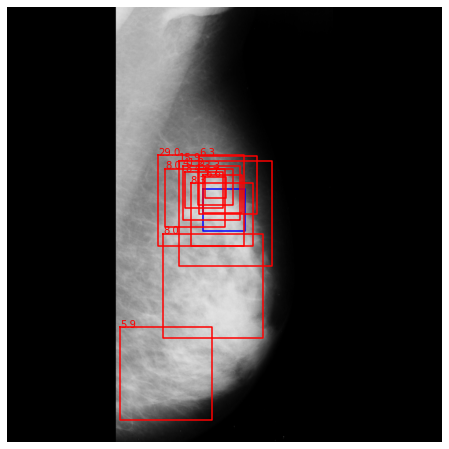

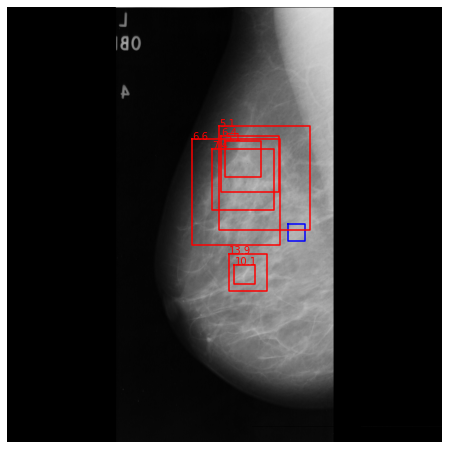

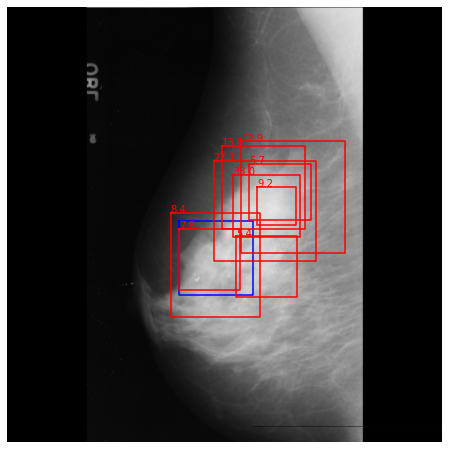

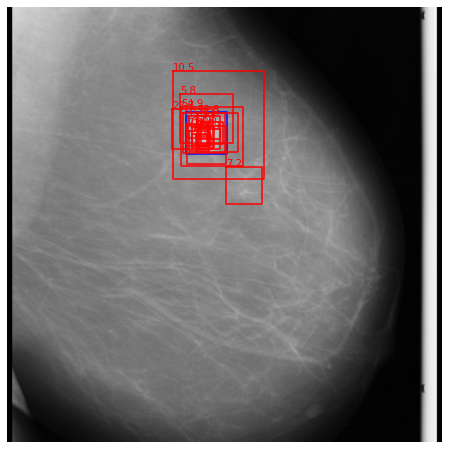

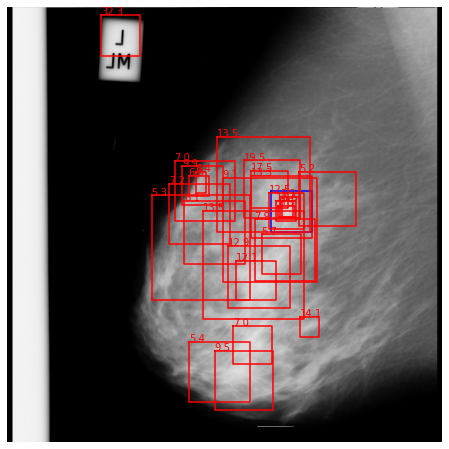

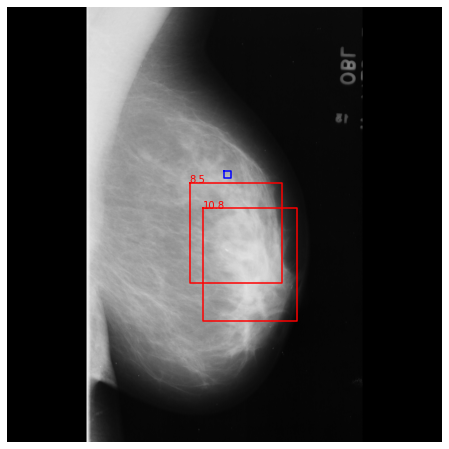

In [ ]:
model.eval()
for i, values in enumerate(test_data_loader):
        images, targets = values

        # Create list of input images
        images = list(image.cuda() for image in images)
        # Create list of ground-truth dicionnaries
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

        # Feed the training samples to the model
        # The model returns  the predictions
        predictions = model(images)

        visualize(images[0], targets[0], predictions[0])

## 6.b. Evaluation

Exécutez le code suivant pour calculer la métrique "mean Average Precision" sur le test set.

In [ ]:
from engine import evaluate
device = torch.device('cuda:{}'.format(gpu_number))
evaluate(model, test_data_loader, device)

creating index...
index created!
Test:  [0/6]  eta: 0:00:02  model_time: 0.1761 (0.1761)  evaluator_time: 0.0070 (0.0070)  time: 0.4170  data: 0.2189  max mem: 6114
Test:  [5/6]  eta: 0:00:00  model_time: 0.1730 (0.1727)  evaluator_time: 0.0019 (0.0028)  time: 0.2298  data: 0.0412  max mem: 6114
Test: Total time: 0:00:01 (0.2515 s / it)
Averaged stats: model_time: 0.1730 (0.1727)  evaluator_time: 0.0019 (0.0028)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50